In [211]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
pwd

'C:\\Users\\Miya\\Desktop\\viz\\house_pred_ML'

In [238]:
train = pd.read_csv("data/train.csv",index_col = 0)
test = pd.read_csv("data/test.csv",index_col = 0)

In [6]:
train.shape

(1460, 81)

In [7]:
test.shape

(1459, 80)

In [164]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
pd.DataFrame(train.isnull().sum(),columns = ['missingVal']).query('missingVal>0').sort_values(by = 'missingVal',ascending = False)

,missingVal
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81
GarageQual,81


In [5]:
pd.DataFrame(test.isnull().sum(),columns = ['missingVal']).query('missingVal>0').sort_values(by = 'missingVal',ascending = False)

,missingVal
PoolQC,1456
MiscFeature,1408
Alley,1352
Fence,1169
FireplaceQu,730
LotFrontage,227
GarageCond,78
GarageYrBlt,78
GarageQual,78
GarageFinish,78


In [231]:
col_drop = list(pd.DataFrame(train.isnull().sum(),columns = ['missingVal'])
                .query('missingVal>0')
                .sort_values(by = 'missingVal',ascending = False)
                .index[:4])
print('Drop columns: %s because they contain too many missing values'%col_drop)

Drop columns: ['PoolQC', 'MiscFeature', 'Alley', 'Fence'] because they contain too many missing values


In [239]:
## drop cols
for col in col_drop:
    train = train.drop(col, 1)
    test = test.drop(col,1)
train = train.drop('Utilities', 1) ## no data variety in Utilities
test = test.drop('Utilities', 1)
train = train.drop('GarageYrBlt',1) ## 'GarageYrBlt' duplicate with YearBuilt
test = test.drop('GarageYrBlt',1)

## Handle Missing Value

In [240]:
#other cols containing missing values
col_miss = list(pd.DataFrame(train.isnull().sum(),columns = ['missingVal'])
                .query('missingVal>0')
                .sort_values(by = 'missingVal',ascending = False)
                .index[5:])
print('dtype for col:')
for col in col_miss:
    print(dict(train.dtypes)[col],':',col)

dtype for col:
object : GarageCond
object : BsmtExposure
object : BsmtFinType2
object : BsmtQual
object : BsmtCond
object : BsmtFinType1
object : MasVnrType
float64 : MasVnrArea
object : Electrical


In [241]:
test.ix[np.isnan(test['BsmtFullBath'])].filter(regex = 'Bsmt*',axis = 1)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2189,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN


In [242]:
num_col_miss = ['LotFrontage','GarageYrBlt','MasVnrArea']
cate_col_miss = [x for x in col_miss if x not in num_col_miss]
print('Three numeric cols contain missing values, they are %s \n%d categorical columns have missing values, they are %s'
     %(num_col_miss,len(cate_col_miss),cate_col_miss))

Three numeric cols contain missing values, they are ['LotFrontage', 'GarageYrBlt', 'MasVnrArea'] 
8 categorical columns have missing values, they are ['GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrType', 'Electrical']


In [245]:
# only NA in 'MasVnrType', 'Electrical' means missing value indeed
def false_na(train):
    train['GarageType']=train['GarageType'].replace({np.nan:'noGarage'})
    train['GarageFinish']=train['GarageFinish'].replace({np.nan:'noGarage'})
    train['GarageQual']=train['GarageQual'].replace({np.nan:'noGarage'})
    train['GarageCars']=train['GarageCars'].replace({np.nan:0})
    train['GarageArea']=train['GarageArea'].replace({np.nan:'0'})
    train['GarageCond']=train['GarageCond'].replace({np.nan:'noGarage'})
    #train['GarageYrBlt']=train['GarageYrBlt'].replace({np.nan:train['YearBuilt']})
    #train['GarageYrBlt'] = train['GarageYrBlt'].astype(str)
    
    train['BsmtExposure']=train['BsmtExposure'].replace({np.nan:'noBasement'})
    train['BsmtFinType2']=train['BsmtFinType2'].replace({np.nan:'noBasement'})
    train['BsmtFinType1']=train['BsmtFinType1'].replace({np.nan:'noBasement'})
    train['BsmtCond']=train['BsmtCond'].replace({np.nan:'noBasement'})
    train['BsmtQual']=train['BsmtQual'].replace({np.nan:'noBasement'})
    train['TotalBsmtSF']=train['TotalBsmtSF'].replace({np.nan:0})
    train['BsmtFinSF1']=train['BsmtFinSF1'].replace({np.nan:0})
    train['BsmtFinSF2']=train['BsmtFinSF2'].replace({np.nan:0})
    train['BsmtUnfSF']=train['BsmtUnfSF'].replace({np.nan:0})
    train['TotalBsmtSF']=train['TotalBsmtSF'].replace({np.nan:0})
    train['BsmtHalfBath']=train['BsmtHalfBath'].replace({np.nan:0})
    train['BsmtFullBath']=train['BsmtFullBath'].replace({np.nan:0})

    train['FireplaceQu']=train['FireplaceQu'].replace({np.nan:'noFireplace'})
    train['MasVnrType']=train['MasVnrType'].replace({np.nan:'noMasonryVeneer'})
    train['MasVnrArea']=train['MasVnrArea'].replace({np.nan:0})  
    train['MSZoning']=train['MSZoning'].replace({np.nan:'RL'})  
    train['Functional']=train['Functional'].replace({np.nan:'Typ'})  
    train['Exterior1st']=train['Exterior1st'].replace({np.nan:'VinylSd'})  
    train['Exterior2nd']=train['Exterior2nd'].replace({np.nan:'VinylSd'})  
    train['Electrical']=train['Electrical'].replace({np.nan:'SBrkr'})  
    train['SaleType']=train['SaleType'].replace({np.nan:'WD'}) 
    train['KitchenQual']=train['KitchenQual'].replace({np.nan:'TA'})  
    
    train['LotFrontage']=train['LotFrontage'].replace({np.nan:train['LotFrontage'].median()}) 


# assign missing vals in Functional to 'Typ'
# assign missing vals in Exterior1st to 'VinylSd'
# assign missing vals in Exterior2nd to 'VinylSd'
# assign missing vals in 'Electrical' to 'SBrkr'
# assign missing vals in 'SaleType' to 'WD'
    return train
# so two categorical cols ('MasVnrType', 'Electrical') contain missing value 
# and three numeric cols contain missing value

In [246]:
test = false_na(test)
train = false_na(train)

In [247]:
pd.DataFrame(train.isnull().sum(),columns = ['missingVal']).query('missingVal>0').sort_values(by = 'missingVal',ascending = False)

,missingVal


In [248]:
pd.DataFrame(test.isnull().sum(),columns = ['missingVal']).query('missingVal>0').sort_values(by = 'missingVal',ascending = False)

,missingVal


** Now we've handled all missing values in both test and train set **

Belows are exploration codes. We don't need them for actual data transformation

In [249]:
print(Counter(list(test['GarageCars'])))
print(Counter(list(train['GarageCars'])))

Counter({2.0: 770, 1.0: 407, 3.0: 193, 0.0: 77, 4.0: 11, 5.0: 1})
Counter({2: 824, 1: 369, 3: 181, 0: 81, 4: 5})


In [250]:
## check data types
df_dtypes = pd.DataFrame(train.dtypes,columns=['train_dtypes']).join(pd.DataFrame(test.dtypes,columns=['test_dtypes']))
df_dtypes_diff = df_dtypes.ix[df_dtypes['train_dtypes'] != df_dtypes['test_dtypes']]

## GarageCars and GarageArea
## int64 to float

In [251]:
print(df_dtypes_diff.index[:6])
df_dtypes_diff

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath'],
      dtype='object')


,train_dtypes,test_dtypes
BsmtFinSF1,int64,float64
BsmtFinSF2,int64,float64
BsmtUnfSF,int64,float64
TotalBsmtSF,int64,float64
BsmtFullBath,int64,float64
BsmtHalfBath,int64,float64
GarageCars,int64,float64
GarageArea,int64,object
SalePrice,int64,NaN


In [252]:
for col in df_dtypes_diff.index[:6]:
    train[col] = train[col].astype('float')
train['GarageCars'] = train['GarageCars'].astype('float')
train['GarageCars'] = train['GarageCars'].astype('str')
test['GarageCars'] = test['GarageCars'].astype('str')
test['GarageArea'] = test['GarageArea'].astype('int64')
# check
df_dtypes0 = pd.DataFrame(train.dtypes,columns=['train_dtypes']).join(pd.DataFrame(test.dtypes,columns=['test_dtypes']))
df_dtypes0.ix[df_dtypes0['train_dtypes'] != df_dtypes0['test_dtypes']]

,train_dtypes,test_dtypes
SalePrice,int64,NaN


In [254]:
## let's check all categorical features
categorical_fea = df_dtypes0[df_dtypes0['test_dtypes']=='object'].index
extra_fea_test = []

for col in categorical_fea[:-2]:
    print(col)
    print(train[col].unique())
    print(test[col].unique())
    if not test[col].unique() in train[col].unique():
        print('column %s contrain extra values in test set'% col)
        extra_fea_test.append(col)
    print('---------------------')

MSZoning
['RL' 'RM' 'C (all)' 'FV' 'RH']
['RH' 'RL' 'RM' 'FV' 'C (all)']
---------------------
Street
['Pave' 'Grvl']
['Pave' 'Grvl']
---------------------
LotShape
['Reg' 'IR1' 'IR2' 'IR3']
['Reg' 'IR1' 'IR2' 'IR3']
---------------------
LandContour
['Lvl' 'Bnk' 'Low' 'HLS']
['Lvl' 'HLS' 'Bnk' 'Low']
---------------------
LotConfig
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
---------------------
LandSlope
['Gtl' 'Mod' 'Sev']
['Gtl' 'Mod' 'Sev']
---------------------
Neighborhood
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
['NAmes' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste' 'IDOTRR'
 'Mitchel' 'Timber' 'Me

C:\Users\Miya\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [255]:
extra_fea_test

['Neighborhood',
 'Condition2',
 'HouseStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'BsmtFinType2',
 'Heating',
 'Electrical',
 'GarageCars',
 'GarageQual']

In [265]:
pd.get_dummies(train).corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
MSSubClass,1.000000,-0.356718,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,...,0.014005,-0.045156,-0.014555,0.026359,0.005003,0.016241,0.030002,0.000983,0.024359,-0.051068
LotFrontage,-0.356718,1.000000,0.304522,0.234812,-0.053281,0.116685,0.083348,0.178469,0.214367,0.042463,...,-0.051283,0.128995,-0.023074,-0.091864,-0.021725,-0.036570,-0.018040,0.016250,-0.074146,0.127293
LotArea,-0.139781,0.304522,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,...,-0.015040,0.020039,-0.005722,-0.002292,-0.029126,-0.013208,0.008966,-0.010781,0.005711,0.022635
OverallQual,0.032628,0.234812,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,...,-0.021172,0.327412,-0.057962,-0.225013,-0.103535,-0.041677,-0.044950,-0.025515,-0.143282,0.323295
OverallCond,-0.059316,-0.053281,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,...,-0.019779,-0.156175,-0.050663,0.163684,-0.046367,-0.038888,-0.033444,-0.023873,0.161642,-0.151659
YearBuilt,0.027850,0.116685,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,-0.049107,...,-0.023431,0.346954,0.012122,-0.238463,-0.110233,-0.045601,-0.010104,-0.035785,-0.158427,0.343895
YearRemodAdd,0.040581,0.083348,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,-0.067759,...,-0.039952,0.325647,-0.011431,-0.182733,-0.135942,-0.040294,-0.020727,-0.048056,-0.120577,0.322837
MasVnrArea,0.023573,0.178469,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,-0.071330,...,-0.022686,0.165692,-0.025899,-0.128187,-0.043861,-0.011783,-0.013748,-0.009535,-0.081539,0.162205
BsmtFinSF1,-0.069836,0.214367,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,-0.050117,...,-0.017825,0.044883,0.010652,-0.024778,-0.024832,-0.014874,0.021369,0.000765,-0.019560,0.044912
BsmtFinSF2,-0.065649,0.042463,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,...,0.035715,-0.087162,-0.013098,0.036178,0.048347,-0.015130,-0.026277,-0.007929,0.041207,-0.085761


In [137]:
test['GarageCars'].unique()

array([1.0, 2.0, 3.0, 0.0, 4.0, 5.0, 'noGarage'], dtype=object)

In [201]:
test.ix[pd.isnull(test['Utilities'])]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,Reg,Lvl,NaN,Inside,...,24,0,0,0,0,0,3,2009,ConLD,Normal
485,1946,20,RL,NaN,31220,Pave,IR1,Bnk,NaN,FR2,...,0,144,0,0,0,750,5,2008,WD,Normal


In [98]:
pd.DataFrame(train.isnull().sum(),columns = ['missingVal']).query('missingVal>0').sort_values(by = 'missingVal',ascending = False)

,missingVal
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
MasVnrType,8
MasVnrArea,8
Electrical,1


In [120]:
type(np.nan)

float

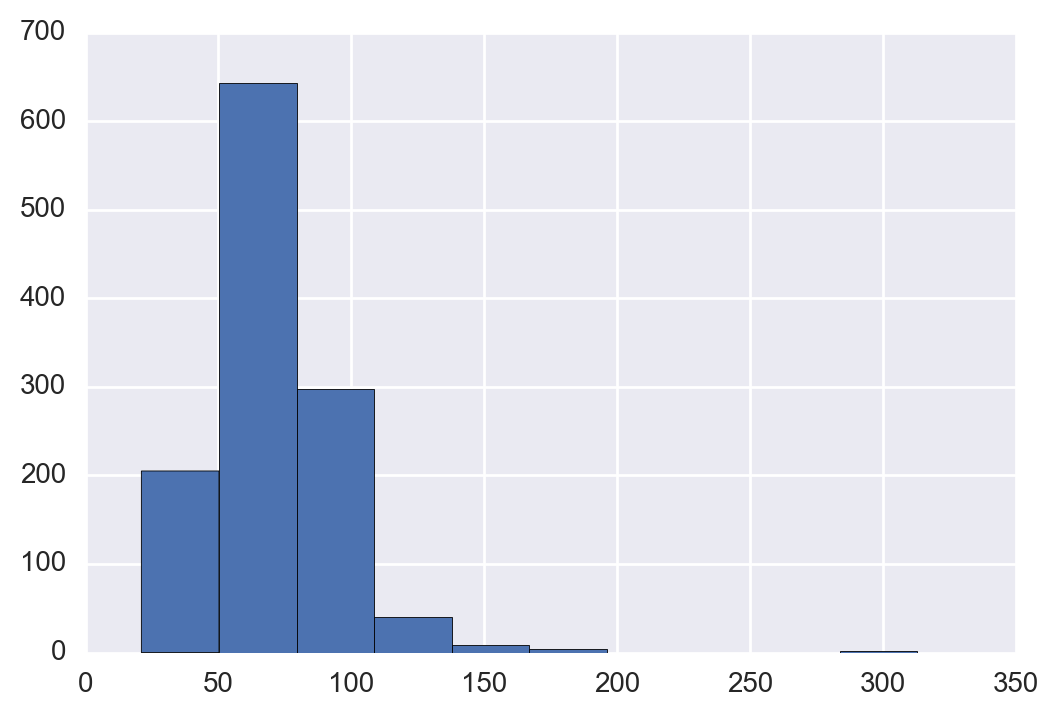

In [41]:
train['LotFrontage'].hist()

In [50]:
print(train['GarageYrBlt'].unique())
print('The newest house built in %d and the oldest built in %d'
      %(train['GarageYrBlt'].max(),train['GarageYrBlt'].min()))

[ 2003.  1976.  2001.  1998.  2000.  1993.  2004.  1973.  1931.  1939.
  1965.  2005.  1962.  2006.  1960.  1991.  1970.  1967.  1958.  1930.
  2002.  1968.  2007.  2008.  1957.  1920.  1966.  1959.  1995.  1954.
  1953.    nan  1983.  1977.  1997.  1985.  1963.  1981.  1964.  1999.
  1935.  1990.  1945.  1987.  1989.  1915.  1956.  1948.  1974.  2009.
  1950.  1961.  1921.  1900.  1979.  1951.  1969.  1936.  1975.  1971.
  1923.  1984.  1926.  1955.  1986.  1988.  1916.  1932.  1972.  1918.
  1980.  1924.  1996.  1940.  1949.  1994.  1910.  1978.  1982.  1992.
  1925.  1941.  2010.  1927.  1947.  1937.  1942.  1938.  1952.  1928.
  1922.  1934.  1906.  1914.  1946.  1908.  1929.  1933.]
The newest house built in 2010 and the oldest built in 1900


In [52]:
for col in cate_col_miss:
    print('%d classes in col %s'%(len(train[col].unique()), col))

7 classes in col GarageType
4 classes in col GarageFinish
6 classes in col GarageQual
6 classes in col GarageCond
5 classes in col BsmtExposure
7 classes in col BsmtFinType2
7 classes in col BsmtFinType1
5 classes in col BsmtCond
5 classes in col BsmtQual
5 classes in col MasVnrType
6 classes in col Electrical


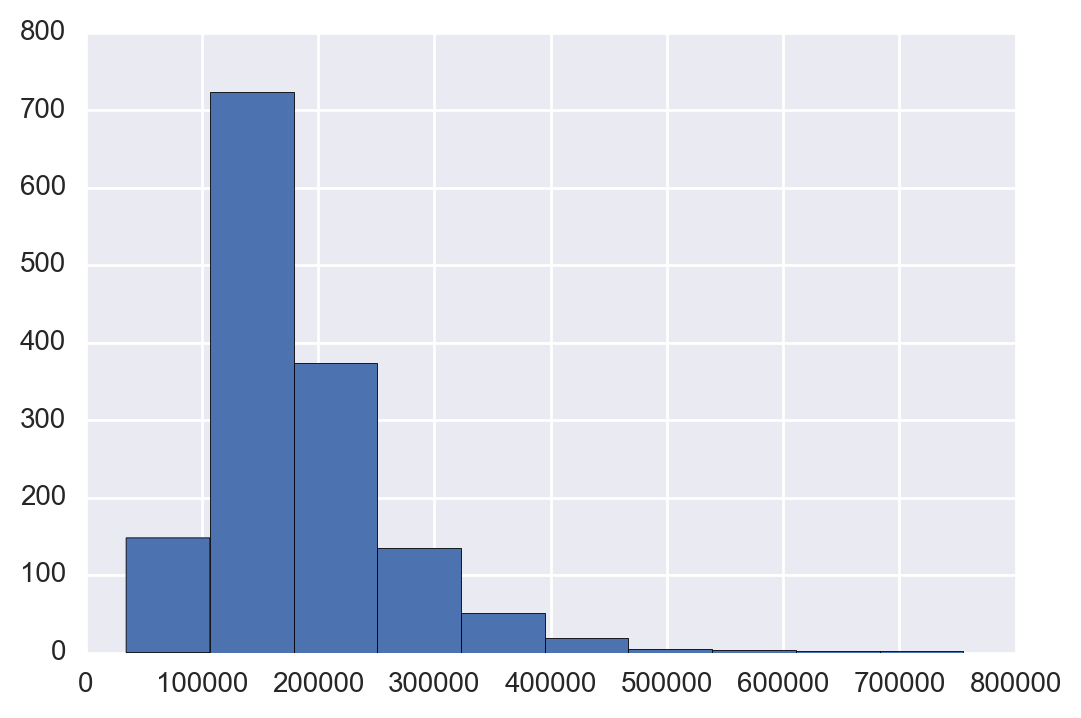

In [55]:
train['SalePrice'].hist()

In [60]:
train[train.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
5,6,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,...,0,320,0,0,700,10,2009,WD,Normal,143000
7,8,60,RL,NaN,10382,Pave,IR1,Lvl,AllPub,Corner,...,228,0,0,0,350,11,2009,WD,Normal,200000
10,11,20,RL,70.0,11200,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,129500
12,13,20,RL,NaN,12968,Pave,IR2,Lvl,AllPub,Inside,...,0,0,176,0,0,9,2008,WD,Normal,144000
14,15,20,RL,NaN,10920,Pave,IR1,Lvl,AllPub,Corner,...,176,0,0,0,0,5,2008,WD,Normal,157000
15,16,45,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Corner,...,0,0,0,0,0,7,2007,WD,Normal,132000
16,17,20,RL,NaN,11241,Pave,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,700,3,2010,WD,Normal,149000
17,18,90,RL,72.0,10791,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,500,10,2006,WD,Normal,90000
18,19,20,RL,66.0,13695,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,6,2008,WD,Normal,159000
